
- **refrence : https://rpubs.com/Oluyole/789742**


# Movie recommendation
- **There are basically two types of movie recommendation system**
- **1.collaberative filtering 2. content based filtering**
- **Here in our project we are doing collaberative filtering movie recommendation system**
- **we built  linear model and matrix factorization model**
- **Dataset:  https://grouplens.org/datasets/movielens/ ml-10M100 **

# Uploading the required R packages

In [1]:
library(caret)
library(cowplot)
library(data.table)
library(dplyr)
library(ggplot2)
library(ggthemes)
library(lubridate)
library(Metrics)
library(recosystem)
library(scales)
library(stringr)
library(tibble)
library(tidyr)
library(readr)
library(gridExtra)
library(dslabs)
library(data.table)
library(ggrepel)

Loading required package: ggplot2

Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'ggthemes'


The following object is masked from 'package:cowplot':

    theme_map



Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from 'package:cowplot':

    stamp


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'Metrics'


The following objects are masked from 'package:caret':

    precision, recall



Attaching pa

# Loading the dataset
- **we took the movielen dataset(https://grouplens.org/datasets/movielens/)**

In [2]:
ratings <- fread(text = gsub("::", "\t", 
                 readLines("C:/Users/pdlpr/Downloads/ml-10M100K/ratings.dat")),
                 col.names = c("userId", "movieId", "rating", "timestamp"))


In [3]:
movies <- str_split_fixed(readLines("C:/Users/pdlpr/Downloads/ml-10M100K/movies.dat"), "\\::", 3)
colnames(movies) <- c("movieId", "title", "genres")

In [4]:
class(movies)
head(movies)

[1] "matrix" "array"

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller


In [5]:
class(ratings)
head(ratings)

[1] "data.table" "data.frame"

userId,movieId,rating,timestamp
<int>,<int>,<dbl>,<int>
1,122,5,838985046
1,185,5,838983525
1,231,5,838983392
1,292,5,838983421
1,316,5,838983392
1,329,5,838983392


- It convertst the movie matrix into dataframe,the onew hich  was created using the str_split_fixed() function to split the text data 

In [6]:
movies <- as.data.frame(movies) 

- We are using integer function to convert the movieId column of the movies data frame from character type to integer type

In [7]:
movies$movieId <- as.integer(movies$movieId)

- Both movies and rating are in right format now we joined it by left_join by mmovieId

In [8]:
mod_movies <- left_join(ratings, movies, by = "movieId")
class(mod_movies)

[1] "data.table" "data.frame"

In [9]:
head(mod_movies)

userId,movieId,rating,timestamp,title,genres
<int>,<int>,<dbl>,<int>,<chr>,<chr>
1,122,5,838985046,Boomerang (1992),Comedy|Romance
1,185,5,838983525,"Net, The (1995)",Action|Crime|Thriller
1,231,5,838983392,Dumb & Dumber (1994),Comedy
1,292,5,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
1,316,5,838983392,Stargate (1994),Action|Adventure|Sci-Fi
1,329,5,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi


- We are going to  split the mod_movies data frame into three subsets: working_set, temp, and validation_set.
- The working set is for training the model, validation is to test the model performance
- The validation set  picks up 10 percent sample data rows from mod_movies, remainig the data are splitted into working_set  - 
- temp contain  but only the rows that were selected by the validation_set.


In [10]:
set.seed(1)
validation_set <- sample(1:nrow(mod_movies), 0.1*nrow(mod_movies)) 
working_set <- mod_movies[-validation_set,]   
temp <- mod_movies[validation_set,]  
summary_table <- data.frame(Dataset = c("mod_movies", "working_set", "temp"),
                            Number_of_ratings = c(nrow(mod_movies), nrow(working_set), nrow(temp)))
print(summary_table)

      Dataset Number_of_ratings
1  mod_movies          10000054
2 working_set           9000049
3        temp           1000005



- Working_set data frame contains all the rows in mod_movies that are not in the test_set
- while the temp data frame contains all the rows in mod_movies that are in the test_set.

In [11]:
set.seed(1)
test_set <- createDataPartition(y = mod_movies$rating, times = 1, p = 0.1, list = FALSE) 
working_set <- mod_movies[-test_set,]  
temp <- mod_movies[test_set,]
tibble(Dataset = c("mod_movies", "working_set", "temp"),
       "Number of ratings" = c(nrow(mod_movies), nrow(working_set), nrow(temp)))

Dataset,Number of ratings
<chr>,<int>
mod_movies,10000054
working_set,9000047
temp,1000007


In [12]:
validation <- temp %>% 
      semi_join(working_set, by = "movieId") %>%
      semi_join(working_set, by = "userId")

In [13]:
removed <- anti_join(temp, validation)
working_set <- rbind(working_set, removed)

Joining with `by = join_by(userId, movieId, rating, timestamp, title, genres)`


# Data exploration

In [14]:
dim(working_set)
structure(working_set)


[1] 9000061       6

userId,movieId,rating,timestamp,title,genres
<int>,<int>,<dbl>,<int>,<chr>,<chr>
1,122,5,838985046,Boomerang (1992),Comedy|Romance
1,185,5,838983525,"Net, The (1995)",Action|Crime|Thriller
1,231,5,838983392,Dumb & Dumber (1994),Comedy
1,292,5,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
1,316,5,838983392,Stargate (1994),Action|Adventure|Sci-Fi
1,329,5,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi
1,355,5,838984474,"Flintstones, The (1994)",Children|Comedy|Fantasy
1,356,5,838983653,Forrest Gump (1994),Comedy|Drama|Romance|War
1,362,5,838984885,"Jungle Book, The (1994)",Adventure|Children|Romance


In [15]:
summary(working_set)


     userId         movieId          rating        timestamp        
 Min.   :    1   Min.   :    1   Min.   :0.500   Min.   :7.897e+08  
 1st Qu.:18122   1st Qu.:  648   1st Qu.:3.000   1st Qu.:9.468e+08  
 Median :35743   Median : 1834   Median :4.000   Median :1.035e+09  
 Mean   :35869   Mean   : 4120   Mean   :3.512   Mean   :1.033e+09  
 3rd Qu.:53602   3rd Qu.: 3624   3rd Qu.:4.000   3rd Qu.:1.127e+09  
 Max.   :71567   Max.   :65133   Max.   :5.000   Max.   :1.231e+09  
    title              genres         
 Length:9000061     Length:9000061    
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

# Rating
The user can give the rating from 0.5 to 5 values.

In [16]:
working_set %>% group_by(rating) %>% summarize(n=n())

rating,n
<dbl>,<int>
0.5,85420
1.0,345935
1.5,106379
2.0,710998
2.5,332783
3.0,2121638
3.5,792037
4.0,2588021
4.5,526309


Two visualaztions using lineplot and bargraph

Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


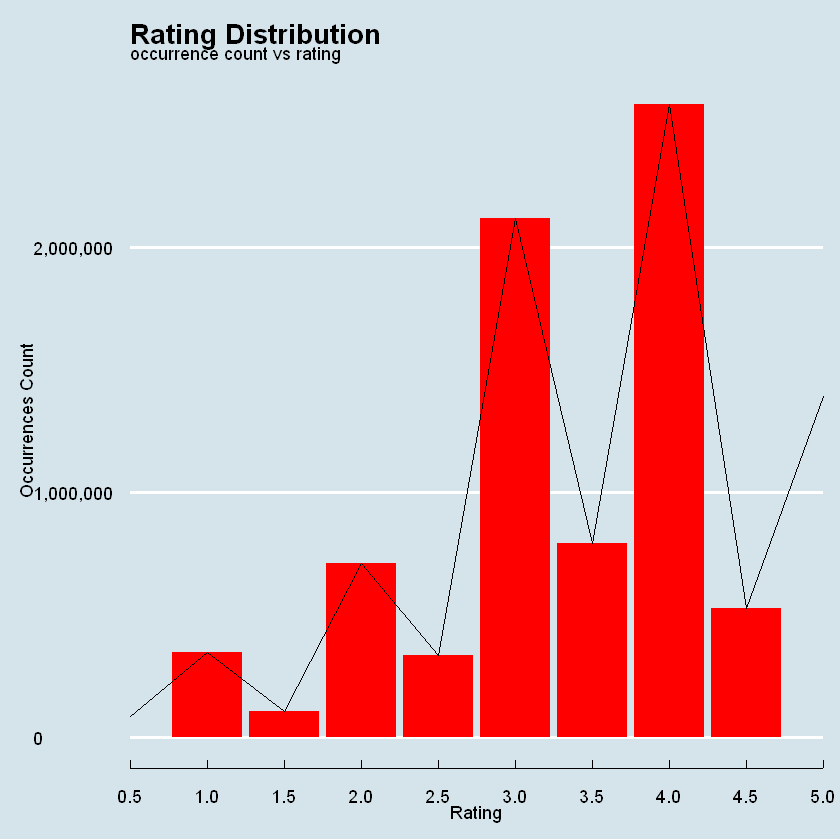

In [17]:
working_set %>%
  group_by(rating) %>%
  summarize(count = n()) %>%
  ggplot() +
  geom_bar(aes(x = rating, y = count), stat = "identity", fill = "red") +
  geom_line(aes(x = rating, y = count), color = "black") +
  ggtitle("Rating Distribution", subtitle = "occurrence count vs rating") +
  xlab("Rating") +
  ylab("Occurrences Count") +
  scale_y_continuous(labels = comma) +
  scale_x_continuous(limits = c(0.5, 5), n.breaks = 10, expand = c(0, 0)) +
  theme_economist()


- ↑↑ From both visualization lineplot and bargraph, we knew that 4 rating scales has highest values and lowest is  0.5,however there is #no ratings. Conditioned on having at least one rating  1.5 is lowest.  

# date/timestamp
The rating period was collected over almost 14 years

In [18]:
sample(as_datetime(working_set$timestamp, origin = "1970-01-01"), replace = TRUE, size = 20)
working_set %>% 
mutate(year = year(as_datetime(timestamp, origin = "1970-01-01"))) %>%
group_by(year) %>%
summarize(count = n())

 [1] "2008-12-19 00:21:50 UTC" "2003-09-01 18:02:30 UTC"
 [3] "2008-11-07 19:55:17 UTC" "2007-01-07 00:35:08 UTC"
 [5] "2000-01-19 08:08:52 UTC" "1996-06-17 18:10:42 UTC"
 [7] "2003-02-10 07:55:02 UTC" "1999-10-20 18:01:56 UTC"
 [9] "2000-07-30 18:24:07 UTC" "2004-01-15 06:45:26 UTC"
[11] "2003-06-01 09:25:43 UTC" "2006-01-08 13:14:18 UTC"
[13] "2003-03-14 04:17:23 UTC" "1999-12-11 20:56:26 UTC"
[15] "1996-07-03 20:18:39 UTC" "2004-07-14 09:08:34 UTC"
[17] "1997-05-26 14:51:53 UTC" "2004-02-26 17:08:27 UTC"
[19] "2004-07-23 06:37:49 UTC" "1999-05-04 16:08:37 UTC"

year,count
<dbl>,<int>
1995,2
1996,942976
1997,414218
1998,181845
1999,709978
2000,1144666
2001,683412
2002,524826
2003,619707


# rating distribution per year

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


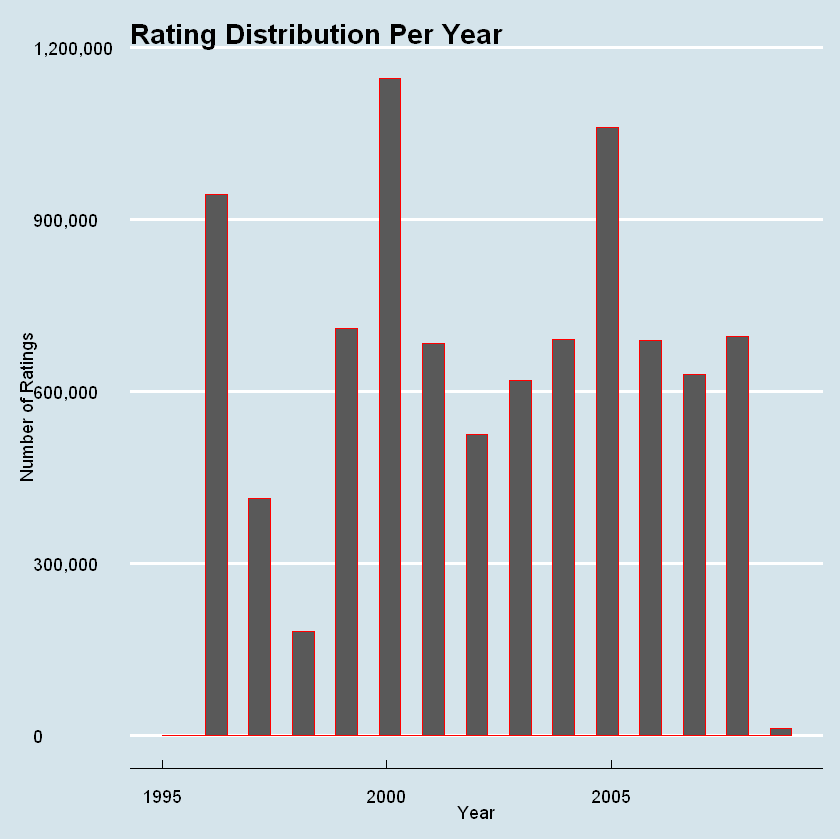

In [19]:
working_set %>% mutate(year = year(as_datetime(timestamp, origin="1970-01-01"))) %>%
  ggplot(aes(x=year)) +
    geom_histogram(color = "Red") + 
    ggtitle("Rating Distribution Per Year") +
    xlab("Year") +
    ylab("Number of Ratings") +
    scale_y_continuous(labels = comma) + 
    theme_economist()

# average rating per year 

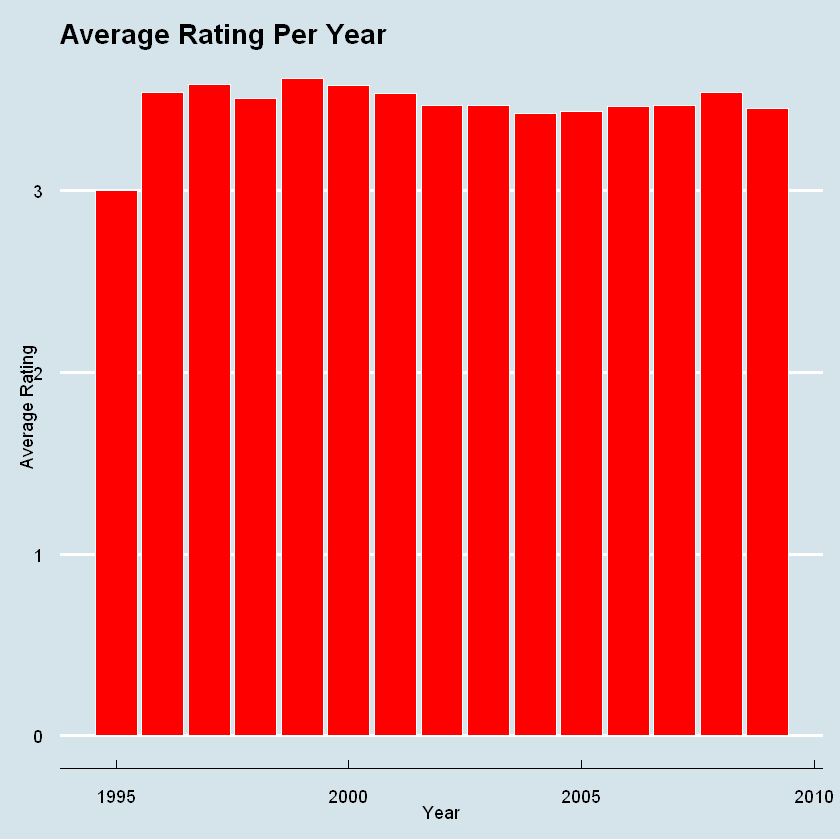

In [20]:
#average rating per year
working_set %>%
  mutate(year = year(as_datetime(timestamp, origin="1970-01-01"))) %>%
  group_by(year) %>%
  summarize(avg_rating = mean(rating)) %>%
  ggplot(aes(x = year, y = avg_rating)) +
    geom_col(fill = "red", color = "white") +
    ggtitle("Average Rating Per Year") +
    xlab("Year") +
    ylab("Average Rating") +
    theme_economist()

# Movies' rating histogram

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


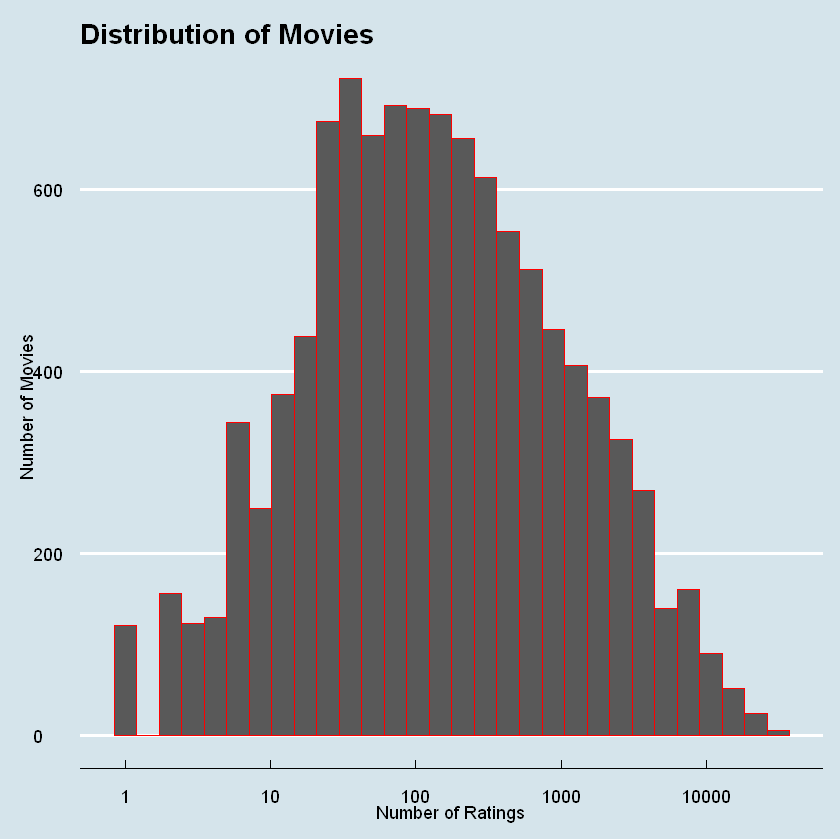

In [21]:
working_set %>% group_by(movieId) %>%
  summarise(n=n()) %>%
  ggplot(aes(n)) +
    geom_histogram(color = "red") +
    scale_x_log10() + 
    ggtitle("Distribution of Movies") +
    xlab("Number of Ratings") +
    ylab("Number of Movies") + 
    theme_economist()

The above ↑↑ histogram seems to be almost symetric and seem to follow normal distribution. Many movies are watched by #few users and only popular movies have more ratings.

# User rating count 

In [22]:
working_set %>% group_by(userId) %>%
  summarise(n=n()) %>%
  arrange(n) %>%
  head()
summary(working_set %>% group_by(userId) %>% summarize(count = n()) %>% select(count))

userId,n
<int>,<int>
22325,13
60448,13
64070,13
3943,14
10560,14
12081,14


     count       
 Min.   :  13.0  
 1st Qu.:  32.0  
 Median :  62.0  
 Mean   : 128.8  
 3rd Qu.: 140.0  
 Max.   :6637.0  

# Users rating histogram

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


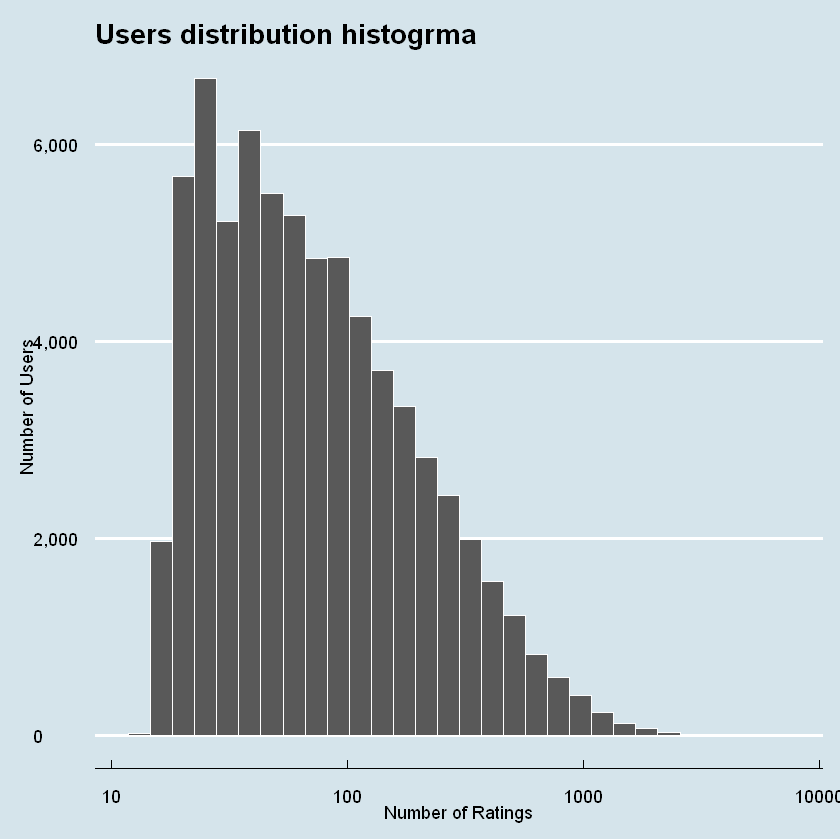

In [23]:
working_set %>% group_by(userId) %>%
  summarise(n=n()) %>%
  ggplot(aes(n)) +
    geom_histogram(color = "white") +
    scale_x_log10() + 
    ggtitle("Users distribution histogrma") +
    xlab("Number of Ratings") +
    ylab("Number of Users") + 
    scale_y_continuous(labels = comma) + 
    theme_economist()

# matrix construction

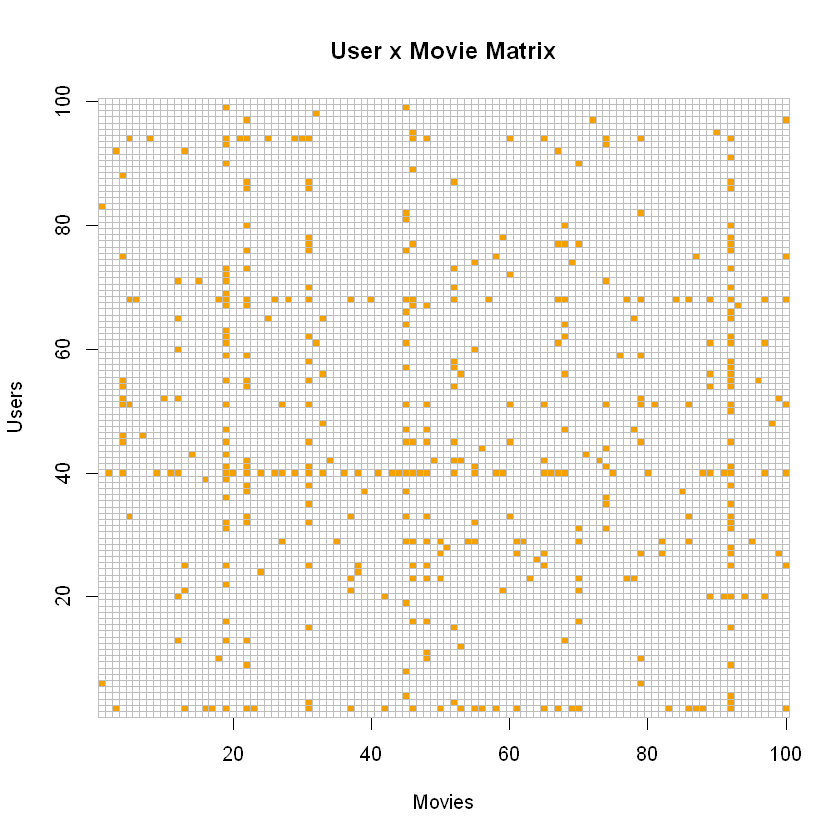

In [24]:
users <- sample(unique(working_set$userId), 100)
working_set %>% filter(userId %in% users) %>%
  select(userId, movieId, rating) %>%
  mutate(rating = 1) %>%
  spread(movieId, rating) %>% 
  select(sample(ncol(.), 100)) %>% 
  as.matrix() %>% t(.) %>%
  image(1:100, 1:100,. , xlab="Movies", ylab="Users")
abline(h=0:100+0.5, v=0:100+0.5, col = "grey")
title("User x Movie Matrix")

The above ↑↑  matrix is thinly distributed, its so sparsed. In the context of this visualization, a sparse dataset is one where most of the entries are empty or zero. We can see very few users are active.

# 3 Generes


The table below shows that several movies are classified in more than one genre.


In [25]:
working_set %>% group_by(genres) %>% 
  summarise(n=n()) %>%
  head()

genres,n
<chr>,<int>
(no genres listed),6
Action,24575
Action|Adventure,68611
Action|Adventure|Animation|Children|Comedy,7438
Action|Adventure|Animation|Children|Comedy|Fantasy,191
Action|Adventure|Animation|Children|Comedy|IMAX,62


we will create a dataframe containing the count of movies in each genre

In [26]:
genres <- c("Action", "Adventure", "Animation", 
            "Children", "Comedy", "Crime", 
            "Documentary", "Drama", "Fantasy", 
            "Film-Noir", "Horror", "Musical", 
            "Mystery", "Romance", "Sci-Fi", 
            "Thriller", "War", "Western")

genres_df <- data.frame(
  Genres = genres,
  Count = sapply(genres, function(x) {
    sum(str_detect(working_set$genres, x))
  })
)

print(genres_df)

                 Genres   Count
Action           Action 2560649
Adventure     Adventure 1908692
Animation     Animation  467220
Children       Children  737851
Comedy           Comedy 3541284
Crime             Crime 1326917
Documentary Documentary   93252
Drama             Drama 3909401
Fantasy         Fantasy  925624
Film-Noir     Film-Noir  118394
Horror           Horror  691407
Musical         Musical  432960
Mystery         Mystery  567865
Romance         Romance 1712232
Sci-Fi           Sci-Fi 1341750
Thriller       Thriller 2325349
War                 War  511330
Western         Western  189234


# Few visualization of generes

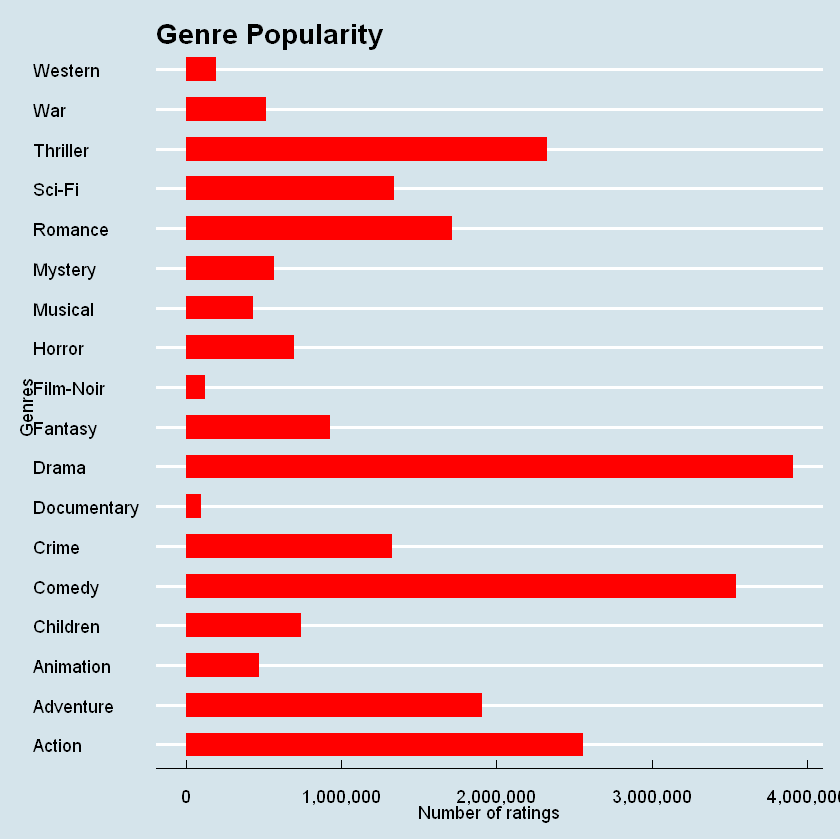

In [27]:
genres_df %>%
  ggplot(aes(x = Count, y = Genres)) +
  ggtitle("Genre Popularity") +
  geom_bar(stat = "identity", width = 0.6, fill = "red") +
  xlab("Number of ratings") +
  ylab("Genres") +
  scale_x_continuous(labels = comma) +
  theme_economist()

In [28]:
#We are making  a new data frame called genres_df_2 that contains two columns: Genres and Rating
genres_df_2 <- data.frame(
  Genres = genres,
  Rating = sapply(genres, function(x) {
    mean(working_set[str_detect(working_set$genres, x)]$rating)
  })
)
print(genres_df_2)

                 Genres   Rating
Action           Action 3.421589
Adventure     Adventure 3.494076
Animation     Animation 3.599588
Children       Children 3.418673
Comedy           Comedy 3.437040
Crime             Crime 3.666151
Documentary Documentary 3.784385
Drama             Drama 3.673047
Fantasy         Fantasy 3.502419
Film-Noir     Film-Noir 4.011732
Horror           Horror 3.269523
Musical         Musical 3.562761
Mystery         Mystery 3.677412
Romance         Romance 3.553594
Sci-Fi           Sci-Fi 3.396756
Thriller       Thriller 3.506879
War                 War 3.779457
Western         Western 3.555122


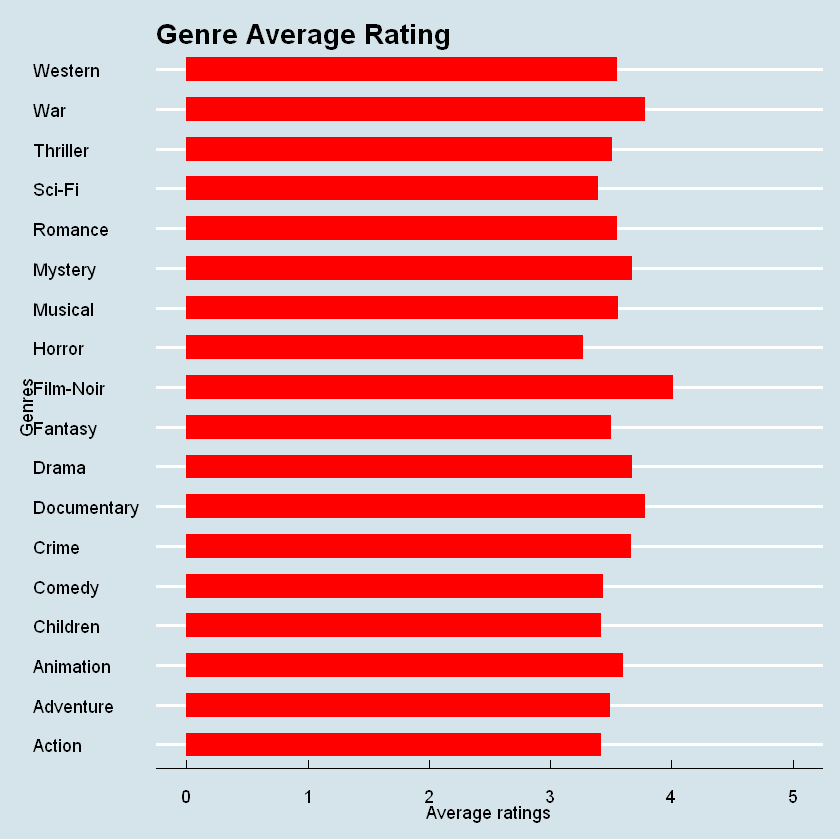

In [29]:
genres_df_2 %>%
  ggplot(aes(x = Rating, y = Genres)) +
  ggtitle("Genre Average Rating") +
  geom_bar(stat = "identity", width = 0.6, fill = "red") +
  xlab("Average ratings") +
  ylab("Genres") +
  scale_x_continuous(labels = comma, limits = c(0.0, 5.0)) +
  theme_economist() 

In [30]:
cat("Number of rows:", dim(working_set)[1], "\n")
cat("Number of columns:", dim(working_set)[2], "\n")

Number of rows: 9000061 
Number of columns: 6 


- How many zeros were given as ratings in the training dataset?


In [31]:
working_set %>%
  filter(rating == 0.0) %>%
  nrow()

[1] 0

- how many five star are given?

In [32]:
sum(working_set$rating == 5.0)

[1] 1390541

How many different movies are in the training dataset?¶

In [33]:
working_set %>%
  distinct(movieId) %>%
  nrow()

[1] 10677

how many users and movies are in trainig dataset?

In [34]:
working_set %>%
  summarise(n_movies = n_distinct(movieId),
            n_users = n_distinct(userId))

n_movies,n_users
<int>,<int>
10677,69878


- How many movie ratings belong to the drama, comedy, thriller and romance genres (respectively) in the working_set dataset?

In [35]:
genres_quiz <- c("Romance", "Crime", "Thriller", "Action")
sapply(genres_quiz, function(x) {
  sum(str_detect(working_set$genres, x))
})

Romance    Crime Thriller   Action 
 1712232  1326917  2325349  2560649

# we are going to perform random prediction, linear model, and matrix factorization.

- Train-test split using createDataPartition


In [36]:
set.seed(1)
train_index <- createDataPartition(mod_movies$rating, times = 1, p = 0.9, list = FALSE)
train_set <- mod_movies[train_index,]
temp_test_set <- mod_movies[-train_index,]

tibble(Dataset = c("mod_movies", "train_set", "temp_test_set"),
       "Number of ratings" = c(nrow(mod_movies), nrow(train_set), nrow(temp_test_set)))

Dataset,Number of ratings
<chr>,<int>
mod_movies,10000054
train_set,9000050
temp_test_set,1000004


In [37]:
set.seed(1)
test_index <- createDataPartition(y = mod_movies$rating, times = 1, p = 0.1, list = FALSE)
train_set <- mod_movies[-test_index,]
temp_test_set <- mod_movies[test_index,]

tibble(Dataset = c("mod_movies", "train_set", "temp_test_set"),
       "Number of ratings" = c(nrow(mod_movies), nrow(train_set), nrow(temp_test_set)))

Dataset,Number of ratings
<chr>,<int>
mod_movies,10000054
train_set,9000047
temp_test_set,1000007


we will be doing a random predection whoch selects 1000 ratings from the training set and calculates the accuracy of the model's predictions for each possible rating value (from 0.5 to 5 in increments of 0.5) .This prediction might not be right so we will use more other models.

In [38]:
set.seed(1)
guess_right <- function(x, y) mean(y == x)
simulation <- replicate(10000, {
  i <- sample(train_set$rating, 1000, replace = TRUE)
  sapply(seq(0.5, 5, 0.5), guess_right, i)
})
guess_prob <- rowMeans(simulation)
y_hat_random <- sample(seq(0.5, 5, 0.5), nrow(validation), replace = TRUE, prob = guess_prob)

In [39]:
test_set <- temp_test_set %>% 
      semi_join(train_set, by = "movieId") %>%
      semi_join(train_set, by = "userId")

In [40]:
removed <- anti_join(temp_test_set, test_set)
train_set <- rbind(train_set, removed)

Joining with `by = join_by(userId, movieId, rating, timestamp, title, genres)`


**Evalation table is created using using four columns Model, MAE,MSE,RMSE. And model table contain three models called cinemathch, netflix prizr and random guessing.
**The mean absolute error(MAE), mean squared error (MSE), and root mean squared error (RMSE) are evaluation metrics provide a quantitative measure of the accuracy of the recommendations made by the algorithm
**Having higher MSE, MAE, and RMSE values indicates poorer performance, so lesser these values more good is the model perfromance

In [41]:
evaluation <- tibble(
  Model = c("Cinematch", "The Netflix Prize", "Random guessing"),
  MAE = c(NA, NA, Metrics::mae(validation$rating, y_hat_random)),
  MSE = c(NA, NA, Metrics::mse(validation$rating, y_hat_random)),
  RMSE = c(0.9525, 0.85725, Metrics::rmse(validation$rating, y_hat_random))
)

print(evaluation)

# A tibble: 3 × 4
  Model               MAE   MSE  RMSE
  <chr>             <dbl> <dbl> <dbl>
1 Cinematch         NA    NA    0.952
2 The Netflix Prize NA    NA    0.857
3 Random guessing    1.17  2.25 1.50 



The initial prediction is just the mean of the ratings, μ
.

# Linear Regression Model using mean baseline 

We will calculate the mean of rating for train_set, also we are adding new columns called mean baseline it helps to compare the performance between more complex model and simple models

In [42]:
mu <- mean(train_set$rating)
y_hat_mean <- rep(mu, nrow(validation))

evaluation <- bind_rows(evaluation, tibble(Model = "Linear model (mean baseline)",
                                           MAE = Metrics::mae(validation$rating, y_hat_mean),
                                           MSE = Metrics::mse(validation$rating, y_hat_mean),
                                           RMSE = Metrics::rmse(validation$rating, y_hat_mean)))
print(evaluation)

# A tibble: 4 × 4
  Model                           MAE   MSE  RMSE
  <chr>                         <dbl> <dbl> <dbl>
1 Cinematch                    NA     NA    0.952
2 The Netflix Prize            NA     NA    0.857
3 Random guessing               1.17   2.25 1.50 
4 Linear model (mean baseline)  0.856  1.12 1.06 


Bias per movie

In [43]:
b_i <- train_set %>%
  group_by(movieId) %>% 
  summarize(b_i = mean(rating - mu),
            b_i_isolated = mean(rating))
b_i %>% slice_head(n = 10)

movieId,b_i,b_i_isolated
<int>,<dbl>,<dbl>
1,0.41377207,3.926236
2,-0.30974866,3.202715
3,-0.36245688,3.150007
4,-0.63215998,2.880304
5,-0.43374223,3.078722
6,0.29904188,3.811506
7,-0.14727767,3.365186
8,-0.39532464,3.117139
9,-0.51684994,2.995614


# Isolated movie bias
histogram of the movie-specific bias term b_i_isolated for each movie in the training set

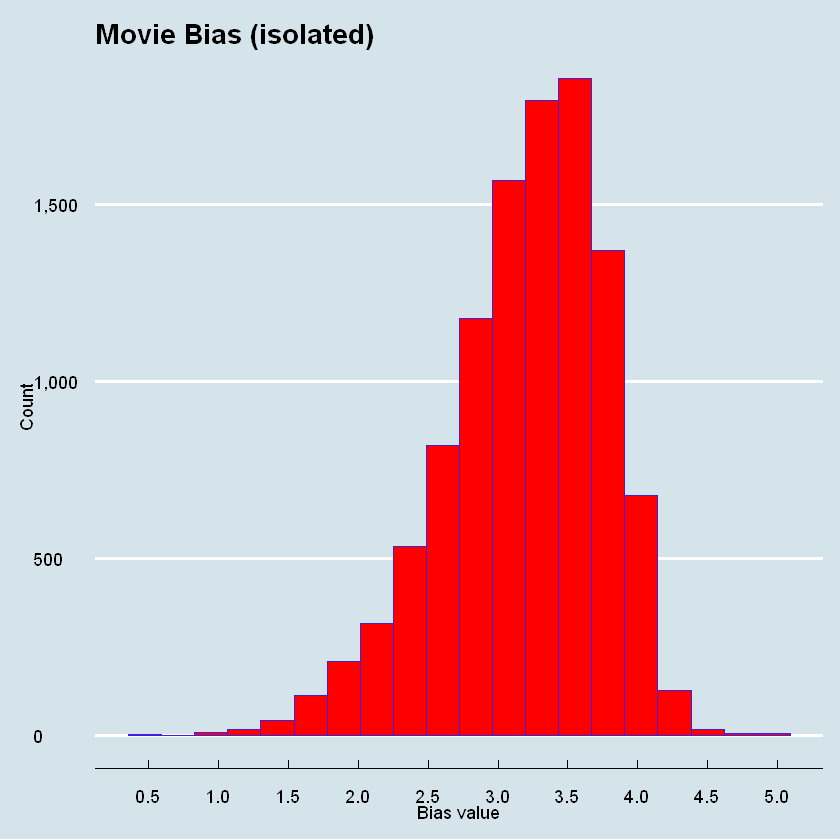

In [44]:
b_i_isolated_plot <- b_i %>%
  ggplot(aes(x = b_i_isolated)) + 
  geom_histogram(bins = 20, fill = "red", color = "#4020dd") +
  ggtitle("Movie Bias (isolated)") +
  xlab("Bias value") +
  ylab("Count") +
  scale_y_continuous(labels = comma) +
  scale_x_continuous(n.breaks = 10) +
  theme_economist() 
b_i_isolated_plot

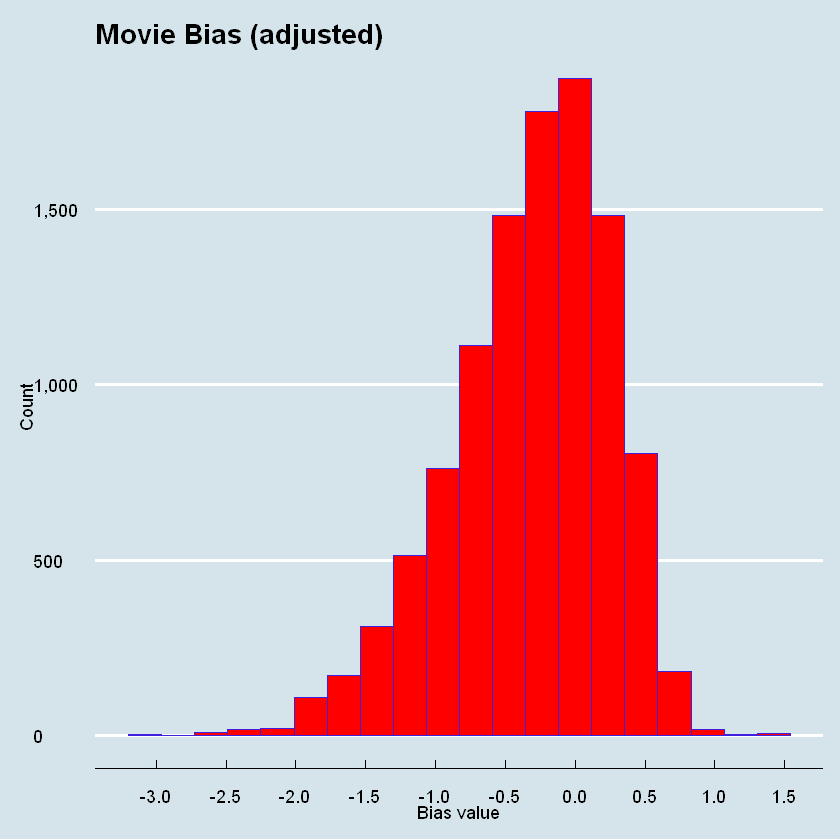

In [45]:
b_i_plot <- b_i %>%
  ggplot(aes(x = b_i)) + 
  geom_histogram(bins = 20, fill = "red", color = "#4020dd") +
  ggtitle("Movie Bias (adjusted)") +
  xlab("Bias value") +
  ylab("Count") +
  scale_y_continuous(labels = comma) +
  scale_x_continuous(n.breaks = 10) +
  theme_economist()
b_i_plot

# Linear Model construction (mean + movie bias)

Certan movies can be rated higher or lower than the overall mean rating so we are adding movie-specific bias term to the mean baseline mode to to compare the performance of the two models (mean baseline and mean + movie bias.

In [46]:
y_hat_b_i <- mu + validation %>%
  left_join(b_i, by = "movieId") %>%
  .$b_i

evaluation <- bind_rows(evaluation,
                        tibble(Model = "Linear model (mean + movie bias)",
                               MAE = Metrics::mae(validation$rating, y_hat_b_i),
                               MSE = Metrics::mse(validation$rating, y_hat_b_i),
                               RMSE = Metrics::rmse(validation$rating, y_hat_b_i)))
print(evaluation)

# A tibble: 5 × 4
  Model                               MAE    MSE  RMSE
  <chr>                             <dbl>  <dbl> <dbl>
1 Cinematch                        NA     NA     0.952
2 The Netflix Prize                NA     NA     0.857
3 Random guessing                   1.17   2.25  1.50 
4 Linear model (mean baseline)      0.856  1.12  1.06 
5 Linear model (mean + movie bias)  0.738  0.891 0.944


In [47]:
mu <- mean(train_set$rating)
y_hat_mean <- rep(mu, nrow(validation))

evaluation <- bind_rows(evaluation, tibble(Model = "Linear model (mean baseline)",
                                           MAE = Metrics::mae(validation$rating, y_hat_mean),
                                           MSE = Metrics::mse(validation$rating, y_hat_mean),
                                           RMSE = Metrics::rmse(validation$rating, y_hat_mean)))
print(evaluation)


# A tibble: 6 × 4
  Model                               MAE    MSE  RMSE
  <chr>                             <dbl>  <dbl> <dbl>
1 Cinematch                        NA     NA     0.952
2 The Netflix Prize                NA     NA     0.857
3 Random guessing                   1.17   2.25  1.50 
4 Linear model (mean baseline)      0.856  1.12  1.06 
5 Linear model (mean + movie bias)  0.738  0.891 0.944
6 Linear model (mean baseline)      0.856  1.12  1.06 


 In above result We can see Linear model (mean + movie bias) is performing better than the other models

In [48]:
b_u <- train_set %>%
  left_join(b_i, by = 'movieId') %>%
  group_by(userId) %>% 
  summarize(b_u = mean(rating - mu - b_i),
            b_u_isolated = mean(rating))
b_u %>% slice_head(n = 10)

userId,b_u,b_u_isolated
<int>,<dbl>,<dbl>
1,1.71053746,5.000000
2,-0.38542913,3.166667
3,0.30621872,3.983333
4,0.66057548,4.057143
5,0.01900505,3.837500
6,0.32178944,3.897436
7,0.07153407,3.915842
8,0.19939428,3.385694
9,0.04766464,3.850000


#Isolated user bias plot

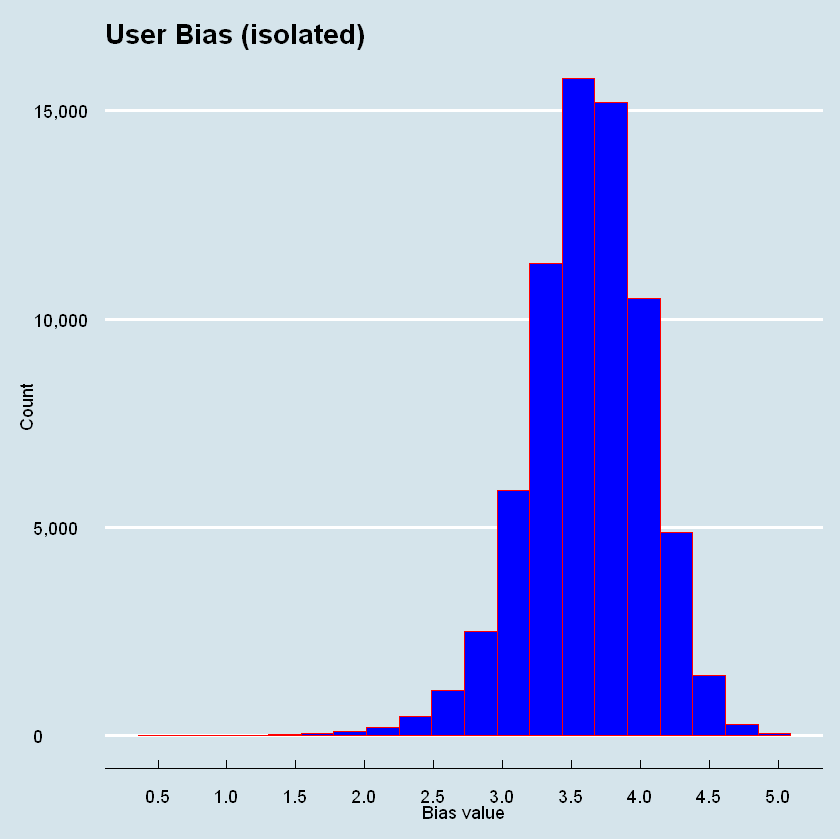

In [49]:
b_u_isolated_plot <- b_u %>%
  ggplot(aes(x = b_u_isolated)) + 
  geom_histogram(bins = 20, fill = "blue", color = "red") +
  ggtitle("User Bias (isolated)") +
  xlab("Bias value") +
  ylab("Count") +
  scale_y_continuous(labels = comma) +
  scale_x_continuous(n.breaks = 10) +
  theme_economist() 
b_u_isolated_plot

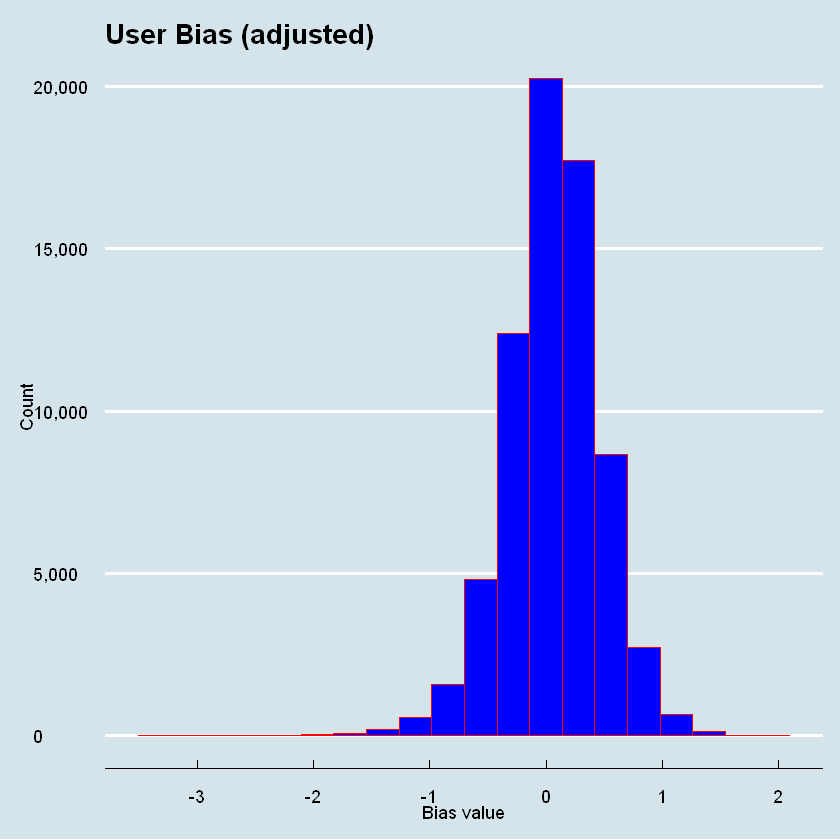

In [50]:
b_u_plot <- b_u %>%
  ggplot(aes(x = b_u)) + 
  geom_histogram(bins = 20, fill = "blue", color = "red") +
  ggtitle("User Bias (adjusted)") +
  xlab("Bias value") +
  ylab("Count") +
  scale_y_continuous(labels = comma) +
  scale_x_continuous(n.breaks = 10) +
  theme_economist()
b_u_plot

In [51]:
y_hat_b_u <- validation %>%
  left_join(b_i, by='movieId') %>%
  left_join(b_u, by='userId') %>%
  mutate(y_hat = mu + b_i + b_u) %>%
  .$y_hat

In [52]:
evaluation <- bind_rows(evaluation, 
                        tibble(Model = "Linear model (mean + movie and user bias)",
                               MAE = Metrics::mae(validation$rating, y_hat_b_u),
                               MSE = Metrics::mse(validation$rating, y_hat_b_u),
                               RMSE = Metrics::rmse(validation$rating, y_hat_b_u)))
print(evaluation)

# A tibble: 7 × 4
  Model                                        MAE    MSE  RMSE
  <chr>                                      <dbl>  <dbl> <dbl>
1 Cinematch                                 NA     NA     0.952
2 The Netflix Prize                         NA     NA     0.857
3 Random guessing                            1.17   2.25  1.50 
4 Linear model (mean baseline)               0.856  1.12  1.06 
5 Linear model (mean + movie bias)           0.738  0.891 0.944
6 Linear model (mean baseline)               0.856  1.12  1.06 
7 Linear model (mean + movie and user bias)  0.669  0.749 0.866


In [53]:
titles <- train_set %>% 
  select(movieId, title) %>% 
  distinct()

In [60]:
worst10_prediction_linear <- test_set %>%
  left_join(b_i, by = "movieId") %>%
  left_join(b_u, by = "userId") %>%
  mutate(y_hat = mu + b_i + b_u) %>%
  arrange(b_i) %>%
  select(title) %>%
  unique() %>%
  slice_head(n = 10)
worst10_prediction_linear_df <- data.frame(Title = worst10_prediction_linear,
                                           Rating = rep(NA, 10),
                                           Count = rep(NA, 10))

for (i in 1:10) {
  indexes <- which(test_set$title == as.character(worst10_prediction_linear[i]))
  worst10_prediction_linear_df$Rating[i] <- mean(test_set$rating[indexes])
  worst10_prediction_linear_df$Count[i] <- sum(
    test_set$title == as.character(worst10_prediction_linear[i])
  )
}
print(worst10_prediction_linear_df)

                                                      title    Rating Count
1                                              Grief (1993) 2.5000000     1
2                 War of the Worlds 2: The Next Wave (2008) 0.5000000     1
3                       SuperBabies: Baby Geniuses 2 (2004) 0.5000000     2
4                                  Hip Hop Witch, Da (2000) 0.7500000     2
5                               From Justin to Kelly (2003) 0.8611111    18
6                                     Disaster Movie (2008) 0.6666667     9
7                                 Death of a Dynasty (2003) 4.5000000     1
8                                     Pokémon Heroes (2003) 1.0909091    11
9                                      Roller Boogie (1979) 2.5000000     2
10 Horrors of Spider Island (Ein Toter Hing im Netz) (1960) 3.2500000     2


In [56]:
top10_prediction_linear <- test_set %>%
  left_join(b_i, by = "movieId") %>%
  left_join(b_u, by = "userId") %>%
  mutate(y_hat = mu + b_i + b_u) %>%
  arrange(desc(y_hat)) %>%
  select(title) %>%
  unique() %>%
  slice_head(n = 10)
top10_prediction_linear_df <- data.frame(Title = top10_prediction_linear,
                                         Rating = rep(NA, 10), 
                                         Count = rep(NA, 10))

for (i in 1:10) {
  indexes <- which(test_set$title == as.character(top10_prediction_linear[i]))
  top10_prediction_linear_df$Rating[i] <- mean(test_set$rating[indexes])
  top10_prediction_linear_df$Count[i] <- sum(
    test_set$title == as.character(top10_prediction_linear[i])
  )
}
print(top10_prediction_linear_df)

                                                          title   Rating Count
1                              Shawshank Redemption, The (1994) 4.460006  3138
2                                             Annie Hall (1977) 4.115433   797
3                                         Godfather, The (1972) 4.382237  2038
4  Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) 4.235582  2757
5                                       Schindler's List (1993) 4.343885  2543
6                                             Goodfellas (1990) 4.171083  1283
7                                           Pulp Fiction (1994) 4.119189  3528
8                                           Blade Runner (1982) 4.145026  1548
9                                   Boat, The (Das Boot) (1981) 4.187500   768
10                                   Usual Suspects, The (1995) 4.342851  2504


Regularization helps to prevent from overfitting  or over generaliztion in our model which is taking  three arguments #lambda, train_set, and test_set.The linear model may not fit all the datapoints so regulariztion could give the good fit model.

In [61]:
regularization <- function(lambda, train_set, test_set){
  mu <- mean(train_set$rating)
#movie biase b_i
  b_i <- train_set %>% 
    group_by(movieId) %>%
    summarize(b_i = sum(rating - mu) / (n() + lambda))
    
#user_biase
  b_u <- train_set %>% 
    left_join(b_i, by="movieId") %>%
    filter(!is.na(b_i)) %>%
    group_by(userId) %>%
    summarize(b_u = sum(rating - mu - b_i) / (n() + lambda))
  
#combining the movie bias b_i and user bias b_u with the test dataset,and computes the predicted ratings 
  predicted_ratings <- test_set %>% 
    left_join(b_i, by = "movieId") %>%
    left_join(b_u, by = "userId") %>%
    filter(!is.na(b_i), !is.na(b_u)) %>%
    mutate(pred = mu + b_i + b_u) %>%
    pull(pred)
    return(Metrics::rmse(predicted_ratings, test_set$rating))
}

It is using sequence of lambda values from 0 to 10, with a step size of 0.25 which  is used to evaluate the #effect of different regularization strengths on the performance of the model. 

In [62]:
lambdas <- seq(0, 10, 0.25)
lambdas_rmse <- sapply(lambdas,
                       regularization, 
                       train_set = train_set, 
                       test_set = test_set)
lambdas_tibble <- tibble(Lambda = lambdas, RMSE = lambdas_rmse)
print(lambdas_tibble)

# A tibble: 41 × 2
   Lambda  RMSE
    <dbl> <dbl>
 1   0    0.866
 2   0.25 0.865
 3   0.5  0.865
 4   0.75 0.865
 5   1    0.865
 6   1.25 0.865
 7   1.5  0.865
 8   1.75 0.865
 9   2    0.865
10   2.25 0.865
# … with 31 more rows


The value of Lambda increases from 0 to 2.25, the RMSE decreases gradually from 0.8655329 to 0.8651406

The scatterplot between the  relationship between the "Lambda" variable and the "RMSE" variable

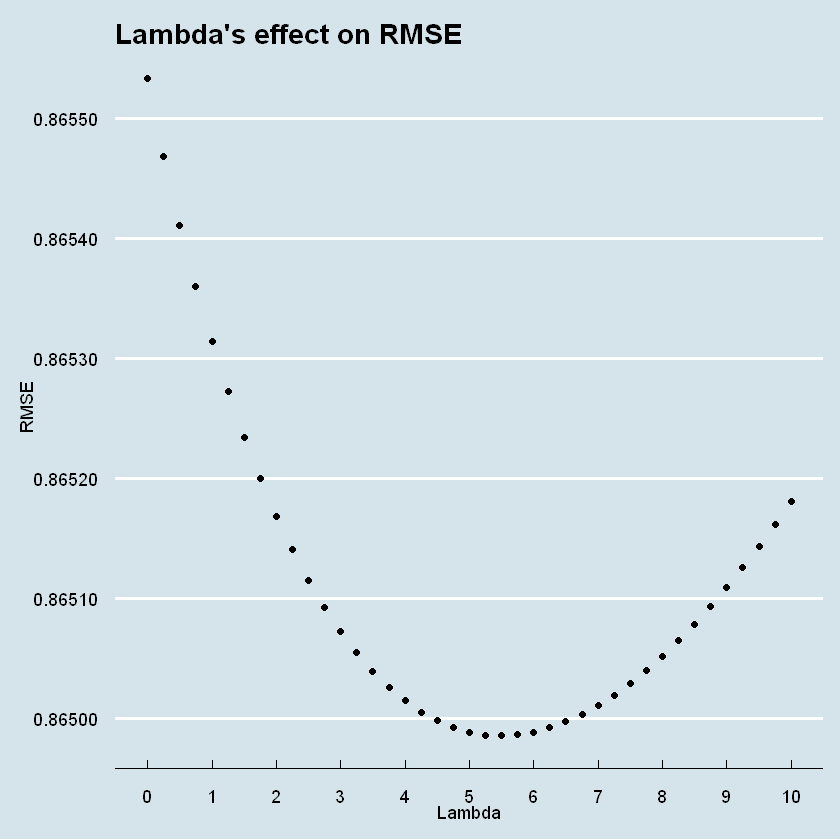

In [63]:
lambdas_tibble %>%
  ggplot(aes(x = Lambda, y = RMSE)) +
  geom_point() +
  ggtitle("Lambda's effect on RMSE") +
  xlab("Lambda") +
  ylab("RMSE") +
  scale_y_continuous(n.breaks = 6, labels = comma) +
  scale_x_continuous(n.breaks = 10) +
  theme_economist()

# We pick the lambda that returns the lowest RMSE.

In [64]:
lambda <- lambdas[which.min(lambdas_rmse)]
mu <- mean(train_set$rating)

Now making regularized bias linear model for movie ratings bycomputing the movie effect and user effect, and then using these effects to make predictions for the validation set.

In [65]:
#Movie effect (bi)
b_i_regularized <- train_set %>% 
  group_by(movieId) %>%
  summarize(b_i = sum(rating - mu)/(n()+lambda))

# User effect (bu)
b_u_regularized <- train_set %>% 
  left_join(b_i, by="movieId") %>%
  group_by(userId) %>%
  summarize(b_u = sum(rating - b_i - mu)/(n()+lambda))


# Prediction
y_hat_regularized <- validation %>% 
  left_join(b_i_regularized, by = "movieId") %>%
  left_join(b_u_regularized, by = "userId") %>%
  mutate(prediction = mu + b_i + b_u) %>%
  pull(prediction)

# Update the result table

evaluation <- bind_rows(evaluation,
                        tibble(Model = "Linear model with regularized bias",
                               MAE  = Metrics::mae(validation$rating, y_hat_regularized),
                               MSE  = Metrics::mse(validation$rating, y_hat_regularized),
                               RMSE = Metrics::rmse(validation$rating, y_hat_regularized)))
print(evaluation)


# A tibble: 8 × 4
  Model                                        MAE    MSE  RMSE
  <chr>                                      <dbl>  <dbl> <dbl>
1 Cinematch                                 NA     NA     0.952
2 The Netflix Prize                         NA     NA     0.857
3 Random guessing                            1.17   2.25  1.50 
4 Linear model (mean baseline)               0.856  1.12  1.06 
5 Linear model (mean + movie bias)           0.738  0.891 0.944
6 Linear model (mean baseline)               0.856  1.12  1.06 
7 Linear model (mean + movie and user bias)  0.669  0.749 0.866
8 Linear model with regularized bias         0.670  0.748 0.865


WE can see that the regularized bias linear model  performs better than the other models, which achieves an MAE of approximately 0.67, an MSE of approximately 0.75, and an RMSE of approximately 0.86.

In [66]:
top10_prediction_regularized <- test_set %>%
  left_join(b_i_regularized, by = "movieId") %>%
  left_join(b_u_regularized, by = "userId") %>%
  mutate(y_hat = mu + b_i + b_u) %>%
  arrange(desc(y_hat)) %>%
  select(title) %>%
  unique() %>%
  slice_head(n = 10)
top10_prediction_regularized_df <- data.frame(Title = top10_prediction_regularized,
                                              Rating = rep(NA, 10),
                                              Count = rep(NA, 10))

In [67]:
for (i in 1:10) {
  indexes <- which(test_set$title == as.character(top10_prediction_regularized[i]))
  top10_prediction_regularized_df$Rating[i] <- mean(test_set$rating[indexes])
  top10_prediction_regularized_df$Count[i] <- sum(
    test_set$title == as.character(top10_prediction_regularized[i])
  )
}
print(top10_prediction_regularized_df)

                                                          title   Rating Count
1                              Shawshank Redemption, The (1994) 4.460006  3138
2                                         Godfather, The (1972) 4.382237  2038
3  Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) 4.235582  2757
4                                             Goodfellas (1990) 4.171083  1283
5                                           Pulp Fiction (1994) 4.119189  3528
6                                           Blade Runner (1982) 4.145026  1548
7                                             Annie Hall (1977) 4.115433   797
8                                       Schindler's List (1993) 4.343885  2543
9                                    Usual Suspects, The (1995) 4.342851  2504
10                             Silence of the Lambs, The (1991) 4.196281  3388


In [68]:
worst10_prediction_regularized <- test_set %>%
  left_join(b_i_regularized, by = "movieId") %>%
  left_join(b_u_regularized, by = "userId") %>%
  mutate(y_hat = mu + b_i + b_u) %>%
  arrange(y_hat) %>%
  select(title) %>%
  unique() %>%
  slice_head(n = 10)
worst10_prediction_regularized_df <- data.frame(Title = worst10_prediction_regularized,
                                                Rating = rep(NA, 10),
                                                Count = rep(NA, 10))

for (i in 1:10) {
  indexes <- which(test_set$title == as.character(worst10_prediction_regularized[i]))
  worst10_prediction_regularized_df$Rating[i] <- mean(test_set$rating[indexes])
  worst10_prediction_regularized_df$Count[i] <- sum(
    test_set$title == as.character(worst10_prediction_regularized[i])
  )
}
print(worst10_prediction_regularized_df)


                                                 title   Rating Count
1     Police Academy 5: Assignment: Miami Beach (1988) 1.858268   127
2                                     RoboCop 3 (1993) 2.182310   277
3                                 Iron Eagle IV (1995) 1.435484    31
4                           Eye of the Beholder (1999) 2.384146    82
5  Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002) 1.100000    25
6                  Turbo: A Power Rangers Movie (1997) 1.320000    50
7                                       Glitter (2001) 1.287500    40
8                     Island of Dr. Moreau, The (1996) 2.398333   300
9                                  Airport 1975 (1974) 2.810811    37
10          Prom Night IV: Deliver Us From Evil (1992) 1.125000    12


the train and test set are converted into reco-system which is created using the data_memory() 
function from the recommenderlab package

# matrix

In [69]:
set.seed(1)
train_recosystem <- with(train_set, data_memory(user_index = userId, 
                                                item_index = movieId,
                                                rating     = rating))
test_recosystem <- with(test_set, data_memory(user_index = userId, 
                                              item_index = movieId, 
                                              rating     = rating))

In [70]:
recommendation_system <- Reco()

we are tunning the model to search for the optimal hyperparameters for a collaborative filtering algorithm
learning rate (0.1 and 0.2),no of iteration 10,dimensionality of the latent factor model (10, 20, and 30),the number of threads (4) is used

In [71]:
tuning <- recommendation_system$tune(train_recosystem, opts = list(dim = c(10, 20, 30),
                                                                   lrate = c(0.1, 0.2),
                                                                   nthread  = 4,
                                                                   niter = 10))

Now time to train the recommendation system on the training dataset using the optimal hyperparameters obtained from tuning


In [72]:
recommendation_system$train(train_recosystem, opts = c(tuning$min,
                                                       nthread = 4,
                                                       niter = 20))

iter      tr_rmse          obj
   0       0.9711   1.1993e+07
   1       0.8718   9.8799e+06
   2       0.8386   9.1718e+06
   3       0.8155   8.7424e+06
   4       0.7996   8.4563e+06
   5       0.7879   8.2574e+06
   6       0.7786   8.1093e+06
   7       0.7708   7.9947e+06
   8       0.7642   7.8982e+06
   9       0.7586   7.8220e+06
  10       0.7535   7.7568e+06
  11       0.7488   7.6972e+06
  12       0.7446   7.6471e+06
  13       0.7409   7.6046e+06
  14       0.7374   7.5646e+06
  15       0.7342   7.5301e+06
  16       0.7312   7.4986e+06
  17       0.7285   7.4709e+06
  18       0.7260   7.4442e+06
  19       0.7237   7.4209e+06


We will use trained recommendation system model to make predictions on the test set

In [73]:
y_hat_MF <-  recommendation_system$predict(test_recosystem, out_memory())

In [74]:
evaluation <- bind_rows(evaluation,
                        tibble(Model = "Matrix factorization",
                               MAE  = Metrics::mae(validation$rating, y_hat_MF),
                               MSE  = Metrics::mse(validation$rating, y_hat_MF),
                               RMSE = Metrics::rmse(validation$rating, y_hat_MF)))
print(evaluation)

# A tibble: 9 × 4
  Model                                        MAE    MSE  RMSE
  <chr>                                      <dbl>  <dbl> <dbl>
1 Cinematch                                 NA     NA     0.952
2 The Netflix Prize                         NA     NA     0.857
3 Random guessing                            1.17   2.25  1.50 
4 Linear model (mean baseline)               0.856  1.12  1.06 
5 Linear model (mean + movie bias)           0.738  0.891 0.944
6 Linear model (mean baseline)               0.856  1.12  1.06 
7 Linear model (mean + movie and user bias)  0.669  0.749 0.866
8 Linear model with regularized bias         0.670  0.748 0.865
9 Matrix factorization                       0.604  0.614 0.783


Among all the models, best model is Matrix factorization.  It has an RMSE of 0.784, which is the lowest among all the models evaluated.

In [75]:
top10_prediction_MF <- tibble(title = test_set$title, y_hat = y_hat_MF) %>%
  arrange(desc(y_hat)) %>%
  select(title) %>%
  unique() %>%
  slice_head(n = 10)
top10_prediction_MF_df <- data.frame(Title = top10_prediction_MF,
                                     Rating = rep(NA, 10),
                                     Count = rep(NA, 10))

for (i in 1:10) {
  indexes <- which(test_set$title == as.character(top10_prediction_MF[i,]))
  top10_prediction_MF_df$Rating[i] <- mean(test_set$rating[indexes])
  top10_prediction_MF_df$Count[i] <- sum(
    test_set$title == as.character(top10_prediction_MF[i,])
  )
}
print(top10_prediction_MF_df)


                                                          title   Rating Count
1                                                 Becket (1964) 3.911765    17
2                                       Cats Don't Dance (1997) 2.968750    16
3         Star Wars: Episode V - The Empire Strikes Back (1980) 4.176275  2255
4                                      Year of the Horse (1997) 2.928571     7
5                              Shawshank Redemption, The (1994) 4.460006  3138
6                               Antonia's Line (Antonia) (1995) 4.002793   179
7                       By the Light of the Silvery Moon (1953) 3.625000     4
8  Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977) 4.235582  2757
9                                           Pulp Fiction (1994) 4.119189  3528
10                                      Schindler's List (1993) 4.343885  2543


In [76]:
worst10_prediction_MF <- tibble(title = test_set$title, y_hat = y_hat_MF) %>%
  arrange(y_hat) %>%
  select(title) %>%
  unique() %>%
  slice_head(n = 10)
worst10_prediction_MF_df <- data.frame(Title = worst10_prediction_MF,
                                       Rating = rep(NA, 10),
                                       Count = rep(NA, 10))

for (i in 1:10) {
  indexes <- which(test_set$title == as.character(worst10_prediction_MF[i,]))
  worst10_prediction_MF_df$Rating[i] <- mean(test_set$rating[indexes])
  worst10_prediction_MF_df$Count[i] <- sum(
    test_set$title == as.character(worst10_prediction_MF[i,])
  )
}
print(worst10_prediction_MF_df)

                                                   title   Rating Count
1                                    Pearl Harbor (2001) 2.910165   423
2                       Beast of Yucca Flats, The (1961) 2.000000     5
3                                       Boys, Les (1997) 2.500000     4
4  Murder on a Sunday Morning (Un coupable idéal) (2001) 3.300000    10
5          Santa Clause 3: The Escape Clause, The (2006) 2.200000     5
6                    Texas Chainsaw Massacre, The (1974) 3.107143   154
7                                         Orphans (1997) 2.900000     5
8                             Switchblade Sisters (1975) 3.133333    15
9                                Rugrats Go Wild! (2003) 1.888889    18
10       Metalstorm: The Destruction of Jared-Syn (1983) 1.500000     5


Both models performed well based on the evaluation metrics and recommended movies, but matrix factorization yielded better results due to its ability to handle non-linear data. 